In [ ]:
try:
    import google.colab
    IN_COLAB = True
    %pip install -q git+https://github.com/neelnanda-io/TransformerLens.git
    %pip install -q circuitsvis
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.8 

In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [ ]:
import circuitsvis as cv
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader, Subset

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import sklearn

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

#more imports 
import matplotlib.pyplot as plt


import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

## Attention Analysis 

There are a couple of experiments to run here. First, is the observation of different types of attention heads. We want to see how attention changes over the course of training (both the number of epochs as well as the size of the model)

In [ ]:
#### CONFIGURATIONS 
STEP_NUM = 143000 
SIZE = '160m' #pythia-70m-deduped', 'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1b-deduped

In [ ]:
def load_model(stepnum, size):
  model = HookedTransformer.from_pretrained(
      f"EleutherAI/pythia-{size}-deduped",
      checkpoint_value=stepnum,
      center_unembed=True,
      center_writing_weights=True,
      fold_ln=True,
      refactor_factored_attn_matrices=True,
  )
  return model 
model = load_model(STEP_NUM, SIZE)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


In [ ]:
def load_attention_pattern(layer_num, some_text, cache):
  attention_pattern = cache[f'blocks.{layer_num}.attn.hook_pattern'] 
  str_tokens = model.to_str_tokens(some_text)
  display(
      cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)
  )
  return attention_pattern 

In [ ]:
## Start off with a simple example. We're going to process a token, and then observe the attention placed on the tokens. 
some_text = "This is a natural language text."
some_tokens = model.to_tokens(some_text)
logits, cache = model.run_with_cache(some_tokens, remove_batch_dim=True)

In [ ]:
attention_pattern = load_attention_pattern(0, some_text, cache)

In [ ]:
def calculate_entropy(model, dataloader):
  uniform_attn_entropy = 0  # entropy of uniform attention
  entropies = np.zeros((model.cfg.n_layers, model.cfg.n_heads))

  for batch in dataloader:
    # tokenize batch 
    some_tokens = model.to_tokens(batch)
    logits, cache = model.run_with_cache(some_tokens, remove_batch_dim=True)

    # get the attention pattern 
    for layer_num in range(model.cfg.n_layers):
      attention_pattern = cache[f'blocks.{layer_num}.attn.hook_pattern'].detach().cpu().numpy()
      attention_pattern = 0.9999 * attention_pattern + (0.0001 / attention_pattern.shape[-1])
      _, token_length, _ = attention_pattern.shape 
        # attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
      if layer_num == 0:
        uniform_attn_entropy -= np.log(1.0 / token_length)
      entropies[layer_num] -= (attention_pattern * np.log(attention_pattern)).sum(-1).mean(-1)

  uniform_attn_entropy /= len(dataloader)
  entropies /= len(dataloader)
  return uniform_attn_entropy, entropies

In [ ]:
from datasets import load_dataset

dataset = load_dataset("NeelNanda/pile-10k")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
sample_indices = np.random.randint(1, 10001, 10).tolist()
subset_dataset = Subset(dataset['train'], sample_indices)

# Create dataloader
dataloader = DataLoader(subset_dataset, batch_size=1, shuffle=False)

In [ ]:
uniform_attn_entropy, entropies = calculate_entropy(model, dataloader)

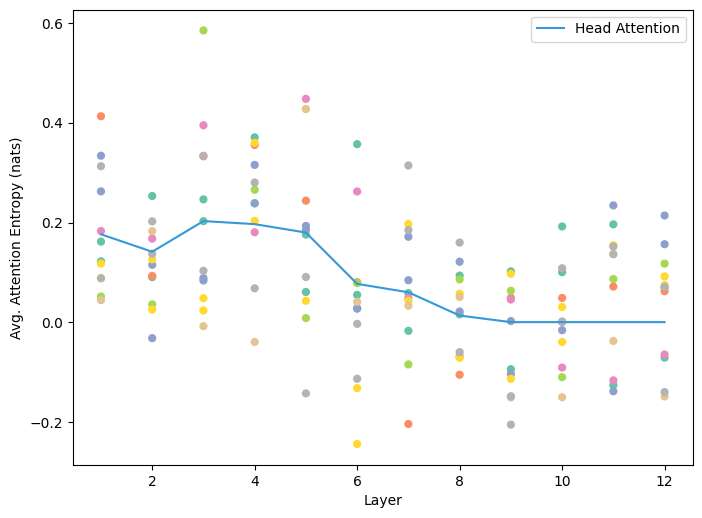

In [ ]:
from matplotlib import pyplot as plt
BLUE = "#3498db"

def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

xs, es, avg_es = get_data_points(entropies)

plt.figure(figsize=(8, 13))

def plot_entropies(ax, data, avgs, label, c):
  
  colors = cm.Set2(np.linspace(0, 1, model.cfg.n_heads))
  for i in range(model.cfg.n_layers):
    jitter = np.random.randn(model.cfg.n_heads) * 0.1
    data_jitter = data[i * model.cfg.n_heads: (i+1)* model.cfg.n_heads] + jitter
    ax.scatter(xs[i * model.cfg.n_heads: (i+1)* model.cfg.n_heads], data_jitter, c=colors, s=24)
  # ax.scatter(xs, data, c=colors, s=23)
  ax.plot(1 + np.arange(model.cfg.n_layers), avgs, c=c, label="Head Attention")
  ax.legend(loc="upper right")
  ax.set_ylabel("Avg. Attention Entropy (nats)")
  ax.set_xlabel("Layer")

plot_entropies(plt.subplot(2, 1, 1), es, avg_es, "BERT Heads",
               c=BLUE)

plt.show()

### Change in Weights Across Timestamps 

By changing the configurations of the plot_differences (make layer_fixed true or false) you can plot out precisely if you are changing layers or fixing layers. 

In [ ]:
import gc 

In [ ]:
# we're doing to find the difference across the attention weights across timestamp 

def get_weights_per_timestamp(steps, model_size, model_cfg): 
  """
  Args:
    steps: array/list of steps that you want to extract the difference from 
  Returns:
    attn_diff: (steps - 1, number of layers, number of heads)
  """
  attn_diff = torch.zeros((len(steps)-1, model_cfg.n_layers, model_cfg.n_heads))
  prev_model = None 

  # get current model 
  for i, step in enumerate(steps):
    gc.collect()
    model = load_model(step, model_size) # load the model 
    if prev_model:
      ## calculate difference between previous model + current_model 
      for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
          for v in ['K', 'V', 'Q']:
            total_tokens = 0
            difference = 0
            for t in ['W', 'b']:
              configuration = f'{t}_{v}'
              current_weight = getattr(model.blocks[layer].attn, configuration)[head]
              prev_weight = getattr(prev_model.blocks[layer].attn, configuration)[head]
              difference += torch.sum((current_weight - prev_weight).abs()) 
              total_tokens += prev_weight.numel()
            attn_diff[i-1, layer, head] += difference / total_tokens  
    prev_model = model 
  return attn_diff.detach().cpu()

In [ ]:
attn_diff = get_weights_per_timestamp([1, 143000], SIZE, model.cfg)

KeyboardInterrupt: ignored

In [ ]:
# Assuming attn_diff is a numpy array
# attn_diff = attn_diff.detach().numpy()
intervals = np.around(np.linspace(0, 143000, 10) / 1000).astype(int) * 1000
attn_diff = get_weights_per_timestamp(intervals, SIZE, model.cfg)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


In [ ]:
import matplotlib.colors as mcolors
import numpy as np
from scipy.spatial.distance import jensenshannon
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib import cm
def plot_differences(attn_diff, time_steps, layer_fixed = None): 
  steps, num_layers, num_heads = attn_diff.shape
  # Create a new figure
  fig, ax = plt.subplots()
  x_labels = [f':{time_steps[0]}'] + [f'{time_steps[i] // 1000}:{time_steps[i+1] // 1000}' for i in range(steps)] 
  x_axis = np.arange(steps)
  if layer_fixed: 
    cmap = cm.Set2(np.linspace(0, 1, model.cfg.n_heads))
    head_diff = attn_diff[:, layer_fixed - 1, :]
    for head in range(num_heads): 
      ax.plot(x_axis, head_diff[:, head], marker='o', label=f"Head {head+1}", color=cmap[head])
  else:
    cmap = cm.magma(np.linspace(0, 0.8, num_layers))
    layer_diff = attn_diff.sum(axis=-1)
    # Set the x-axis to be the steps
    for layer in range(num_layers):
      values = layer_diff[:, layer]
      ax.plot(x_axis, values, marker='o', label=f"Layer {layer+1}", color=cmap[layer])
  # Set the title and labels for the plot
  if layer_fixed:
    ax.set_title(f"Change in Attention Weights for Layer {layer_fixed}")
  else:
    ax.set_title(f"Change in Attention Weights Across Training: Pythia-{SIZE}-{STEP_NUM}")
  ax.set_xlabel("Training Step (in 1000s)")
  ax.set_ylabel("Weight Change")
  ax.set_xticklabels(x_labels, fontsize='small')
  # Show the legend
  plt.legend(loc='upper left', fontsize='small')

  # Show the plot
  plt.show()

<ipython-input-110-850221059b8a>:32: UserWarning:

FixedFormatter should only be used together with FixedLocator



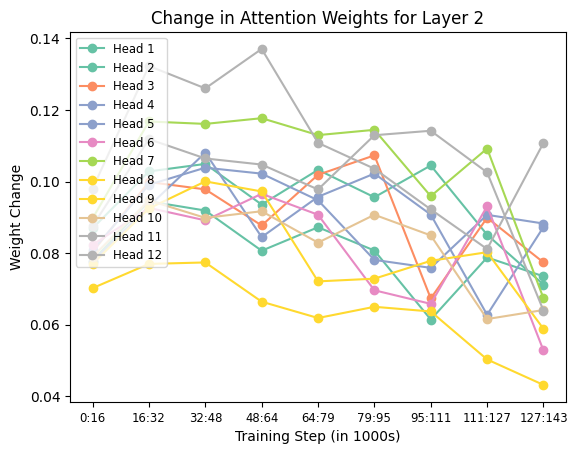

In [ ]:
plot_differences(attn_diff, intervals, layer_fixed = 2)

## Are these heads the most important? 
We will ablate these heads and see :) This is the section on ablations 

In [ ]:
def ablate(model, layer_to_ablate, head_index_to_ablate, example_tokens): 
  def head_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    value[:, :, head_index_to_ablate, :] = 0.
    return value
  original_loss = model(example_tokens, return_type="loss")
  ablated_loss = model.run_with_hooks(
    example_tokens, 
    return_type="loss", 
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate), 
        head_ablation_hook
        )]
    )
  return original_loss, ablated_loss

In [ ]:
layer_to_ablate = 0
head_index_to_ablate = 4

gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.to_tokens(gpt2_text)

original, ablated = ablate(model, layer_to_ablate, head_index_to_ablate, gpt2_tokens)
print(f"Original: {original}, Ablated: {ablated}, Difference: {ablated - original}")

Original: 8.909246444702148, Ablated: 9.086431503295898, Difference: 0.17718505859375


In [ ]:
from tqdm import tqdm

In [ ]:
def check_head_importance(model, dataloader):
  # best_head_layer = [0] * model.cfg.n_layers
  # best_head_index = [0] * model.cfg.n_layers
  importance = np.zeros((model.cfg.n_layers, model.cfg.n_heads))
  for batch in tqdm(dataloader):
    tokens = model.to_tokens(batch)
    for layer in range(model.cfg.n_layers):
      for head in range(model.cfg.n_heads): 
        original, ablated = ablate(model, layer, head, tokens)
        importance[layer][head]+=ablated - original
        # print(f"Original: {original}, Ablated: {ablated}, Difference: {ablated - original}")
        
  return importance

In [ ]:
importance = check_head_importance(model, dataloader)

100%|██████████| 10/10 [11:16<00:00, 67.69s/it]


In [ ]:
max_idx = np.argmax(importance, axis=1)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from skimage.color import rgb2lab, deltaE_cie76

import numpy as np

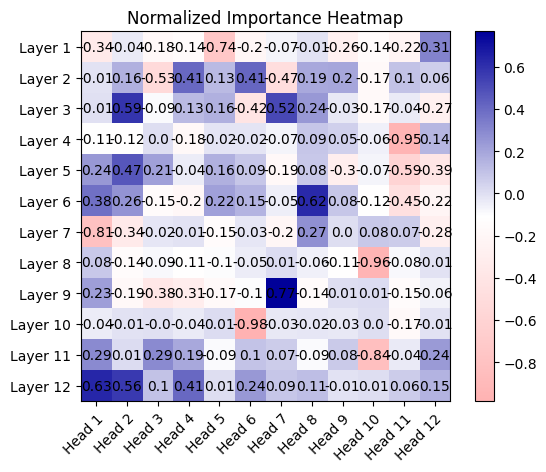

In [ ]:
# Replace 'importance_values' with your matrix of importance values
importance_values_norm = np.linalg.norm(importance, axis=1, keepdims=True)
importance_values = importance / importance_values_norm

# Create a custom color map that goes from white to dark blue
# cmap = colors.LinearSegmentedColormap.from_list("", [(1, 1, 1), (0, 0, 0.6)])
# cmap = colors.LinearSegmentedColormap.from_list("", [(1, 1, 1), (0, 0, 0.6)], gamma=2.8)
# colors.LinearSegmentedColormap.from_list("", [(1, 1, 1), (1, 0.7, 0.7), (0, 0, 0.6)], gamma=0.3, vmin=-1, vmax=1)
# cmap = colors.LinearSegmentedColormap.from_list("", [(1, 1, 1), (0, 0, 0.6)], gamma=2.8)
# cmap = ListedColormap(cmap(np.linspace(0, 1, 256)))
# cmap.set_under((1, 0.7, 0.7))
cmap = colors.LinearSegmentedColormap.from_list("", [(1, 0.7, 0.7), (1, 1, 1), (0, 0, 0.6)])

fig, ax = plt.subplots()


# Create heatmap using 'imshow' function and custom color map
im = ax.imshow(importance_values, cmap=cmap)

# Set the labels for x-axis and y-axis
ax.set_xticks(np.arange(len(importance_values[0])))
ax.set_yticks(np.arange(len(importance_values)))
ax.set_xticklabels(['Head '+str(i+1) for i in range(len(importance_values[0]))])
ax.set_yticklabels(['Layer '+str(i+1) for i in range(len(importance_values))])

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(importance_values)):
    for j in range(len(importance_values[0])):
      # Get the cell color and calculate its luminance
        cell_color = cmap(importance_values[i, j])
        lab_cell_color = rgb2lab(cell_color[1:])
        luminance = lab_cell_color[0]

        # Determine the label color based on the luminance
        label_color = "black" if luminance > 70 else "white"

        text = ax.text(j, i, round(importance_values[i, j], 2),
                       ha="center", va="center", color=label_color)


# Set title and colorbar
ax.set_title("Normalized Importance Heatmap")
cbar = ax.figure.colorbar(im, ax=ax)

# Show the heatmap
plt.show()

### Distances between Heads


In [ ]:


def distance_heads(dataloader, model):
  total_heads = model.cfg.n_layers * model.cfg.n_heads
  divergences = np.zeros((total_heads, total_heads))

  for batch in dataloader:

    # tokenize batch 
    some_tokens = model.to_tokens(batch)
    logits, cache = model.run_with_cache(some_tokens, remove_batch_dim=True)

    # get the attention pattern 
    for layer_num in range(model.cfg.n_layers):
      attention_matrix = cache[f'blocks.{layer_num}.attn.hook_pattern'].detach().cpu().numpy()

      for i in range(attention_matrix.shape[0]):
        for j in range(i + 1, attention_matrix.shape[0]):
          div = jensenshannon(attention_matrix[i].ravel(), attention_matrix[j].ravel())
          ### TODO: update divergences
          divergences[layer_num*model.cfg.n_heads + i, layer_num*model.cfg.n_heads + j] += div
          divergences[layer_num*model.cfg.n_heads + j, layer_num*model.cfg.n_heads + i] += div
  
  divergences /= len(dataloader)
  # compute Jenson-Shannon divergences between all pairs of attention heads
  return divergences 
  

In [ ]:
def distance_mapping(divergences, model):
  mds = sklearn.manifold.MDS(metric=True, n_init=5, n_jobs=4, eps=1e-10,
                            max_iter=1000, dissimilarity="precomputed")
  pts = mds.fit_transform(divergences)
  pts = pts.reshape((model.cfg.n_layers, model.cfg.n_heads, 2))
  pts_flat = pts.reshape([model.cfg.n_layers * model.cfg.n_heads, 2])

  colormap = cm.seismic(np.linspace(0, 1.0, 12))

  plt.figure(figsize=(4.8, 9.6))
  plt.title("BERT Attention Heads")

  ax = plt.subplot(2, 1, 2)
  seen_labels = set()
  for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
      label = str(layer + 1)
      color = colormap[layer] #FIX TO GRAY 
      marker = "o"
      markersize = 4
      x, y = pts[layer, head]
      if label not in seen_labels:
        seen_labels.add(label)
      else:
        label = ""
      ax.plot([x], [y], marker=marker, markersize=markersize,
              color=color, label=label, linestyle="")
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_visible(False)
  ax.set_facecolor((0.96, 0.96, 0.96))
  plt.title(("Colored by Layer"))
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels, loc="upper left")
  plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                      hspace=0.1, wspace=0)
  plt.show()

In [ ]:
sample_indices = np.random.randint(1, 10001, 100).tolist()
subset_dataset = Subset(dataset['train'], sample_indices)

# Create dataloader
dataloader = DataLoader(subset_dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

<ipython-input-130-467f6f21e241>:13: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



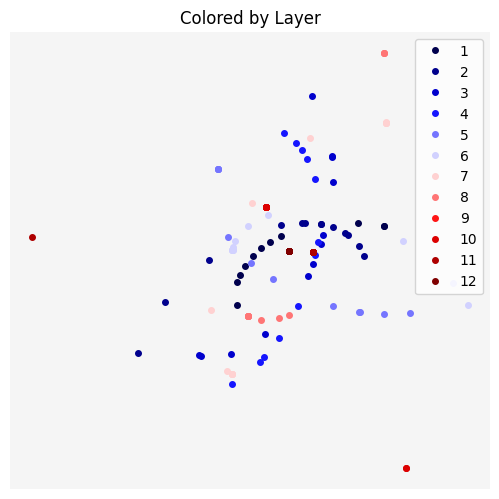

In [ ]:
divergences = distance_heads(dataloader, model)


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

<ipython-input-134-2881eff919e9>:13: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



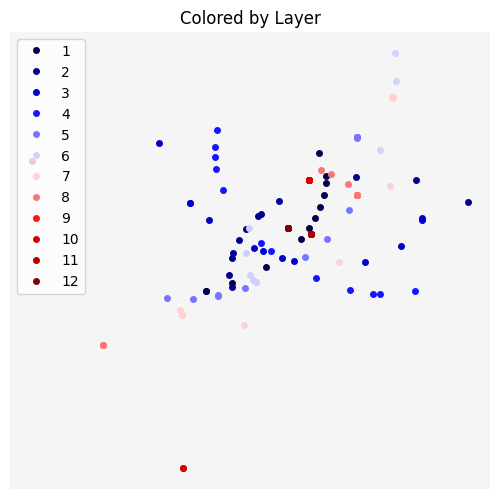

In [ ]:
distance_mapping(divergences, model)

In [ ]:
print(uniform_attn_entropy)

2.0794415416798397


In [ ]:
print(entropies)

[[0.2924675  0.1801948  0.4648011  0.01238537 0.37306896 0.22840241
  0.77660483 0.48994651]
 [0.43921989 0.42372894 0.72353148 0.16417459 0.02681811 0.16296917
  0.38636768 0.2025464 ]
 [0.21835032 0.23998556 0.55757684 0.11814389 0.18583784 0.04930486
  0.00545306 0.54293323]
 [0.00107535 0.00107535 0.24875169 0.00107535 0.1709653  0.00107535
  0.00107535 0.12921578]
 [0.00107535 0.00107535 0.00107535 0.00107535 0.00107535 0.00107535
  0.00107535 0.00107535]
 [0.00107535 0.00107535 0.00107535 0.00107535 0.00107535 0.00107535
  0.00107535 0.00107535]]


### Attention General Analysis 

We will look at 

### Induction **Heads**

In [ ]:
STEP_NUM = 143000 
size = '70m'

In [ ]:
model = load_model(STEP_NUM, SIZE)

Using pad_token, but it is not set yet.


In [ ]:
def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)


In [ ]:
batch_size = 10
seq_len = 50
random_tokens = torch.randint(1000, 10000, (batch_size, seq_len)).to(model.cfg.device)
repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")
repeated_logits = model(repeated_tokens)
correct_log_probs = model.loss_fn(repeated_logits, repeated_tokens, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position on random repeated tokens")

In [ ]:
def get_induction_heads(model, repeated_tokens):
  ## create the score store 
  induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
  
  def induction_score_hook(
      pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
      hook: HookPoint,
  ):
      # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
      # (This only has entries for tokens with index>=seq_len)
      induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
      # Get an average score per head
      induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
      # Store the result.
      induction_score_store[hook.layer(), :] = induction_score

  # We make a boolean filter on activation names, that's true only on attention pattern names.
  pattern_hook_names_filter = lambda name: name.endswith("pattern")

  model.run_with_hooks(
      repeated_tokens, 
      return_type=None, # For efficiency, we don't need to calculate the logits
      fwd_hooks=[(
          pattern_hook_names_filter,
          induction_score_hook
      )]
  )

  return induction_score_store 

In [ ]:
def evaluate_induction(model):
  random_tokens = torch.randint(1000, 10000, (batch_size, seq_len)).to(model.cfg.device)
  repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")
  induction_score = get_induction_heads(model, repeated_tokens)
  #imshow(induction_score, xaxis="Head", yaxis="Layer", title="Induction Score by Head")
  return induction_score

In [ ]:
score = evaluate_induction(model)

In [ ]:
max_index = torch.argmax(score) #num_layers, num_heads 
max_row = max_index // model.cfg.n_layers
max_col = max_index % model.cfg.n_heads
print(max_row)
print(max_col)

tensor(4)
tensor(5)


In [ ]:
imshow(score, xaxis="Head", yaxis="Layer", title="Induction Score by Head")

In [ ]:
induction_head_layer=4
induction_head_index = 5
visualize_induction_head(model, induction_head_layer, induction_head_index)


In [ ]:
def visualize_induction_head(model, induction_head_layer=0, induction_head_index = 6):
  """

  """
  example_text = "Research in mechanistic interpretability seeks to explain behaviors of machine learning models in terms of their internal components."
  example_repeated_text = example_text + example_text
  example_repeated_tokens = model.to_tokens(example_repeated_text, prepend_bos=True)
  example_repeated_logits, example_repeated_cache = model.run_with_cache(example_repeated_tokens)

  # single_random_sequence = torch.randint(1000, 10000, (1, 20)).to(model.cfg.device)
  # repeated_random_sequence = einops.repeat(single_random_sequence, "batch seq_len -> batch (2 seq_len)")
  def visualize_pattern_hook(
      pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
      hook: HookPoint,
  ):
      display(
          cv.attention.attention_patterns(
              tokens=model.to_str_tokens(example_repeated_tokens), 
              attention=pattern[0, induction_head_index, :, :][None, :, :] # Add a dummy axis, as CircuitsVis expects 3D patterns.
          )
      )

  model.run_with_hooks(
      example_repeated_tokens, 
      return_type=None, 
      fwd_hooks=[(
          utils.get_act_name("pattern", induction_head_layer), 
          visualize_pattern_hook
      )]
  )

In [ ]:
print(f'Pythia-{SIZE}-{STEP_NUM}')

Pythia-160m-143000


In [ ]:
batch_size = 10
seq_len = 200
random_tokens = torch.randint(1000, 10000, (batch_size, seq_len)).to(model.cfg.device)
repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")
repeated_logits = model(repeated_tokens)
correct_log_probs = model.loss_fn(repeated_logits, repeated_tokens, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position on random repeated tokens")